[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BRomans/UnicornPythonEssentialsToolkit/blob/main/notebooks/P300_Classification.ipynb)


## Classification

### Load Libraries and Data


In [1]:
from mne import find_events
from utils.loader import load_data, unicorn_fs, unicorn_channels, convert_to_mne
from utils.preprocessing import extract_epochs, basic_preprocessing_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
from utils.validation import plot_confusion_matrix, plot_cross_validated_confusion_matrix

eeg, trigger = load_data("../data/aep/auditory_erp_eyes_open_S1.csv", header=False, fs=unicorn_fs, skiprows=5)
print("Loaded data with shape:" + str(eeg.shape) + " and trigger shape: " + str(trigger.shape))
print("That means we have " + str(eeg.shape[0]) + " samples and " + str(eeg.shape[1]) + " channels.")

 # Convert to MNE format
raw_data = convert_to_mne(eeg, trigger, fs=unicorn_fs, chs=unicorn_channels, recompute=False) # recompute=True to recalculate the event labels if the values are negative

Loaded data with shape:(13627, 8) and trigger shape: (13627,)
That means we have 13627 samples and 8 channels.
Creating RawArray with float64 data, n_channels=8, n_times=13627
    Range : 0 ... 13626 =      0.000 ...    54.504 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=13627
    Range : 0 ... 13626 =      0.000 ...    54.504 secs
Ready.


### Data Preparation


1. Extract events and event ids
2. Preprocess the data  
3. Epoching and baseline correction
4. Resample and split the data


#### 1.Extract events and event ids

90 events found on stim channel STI
Event IDs: [1 2]
Using matplotlib as 2D backend.


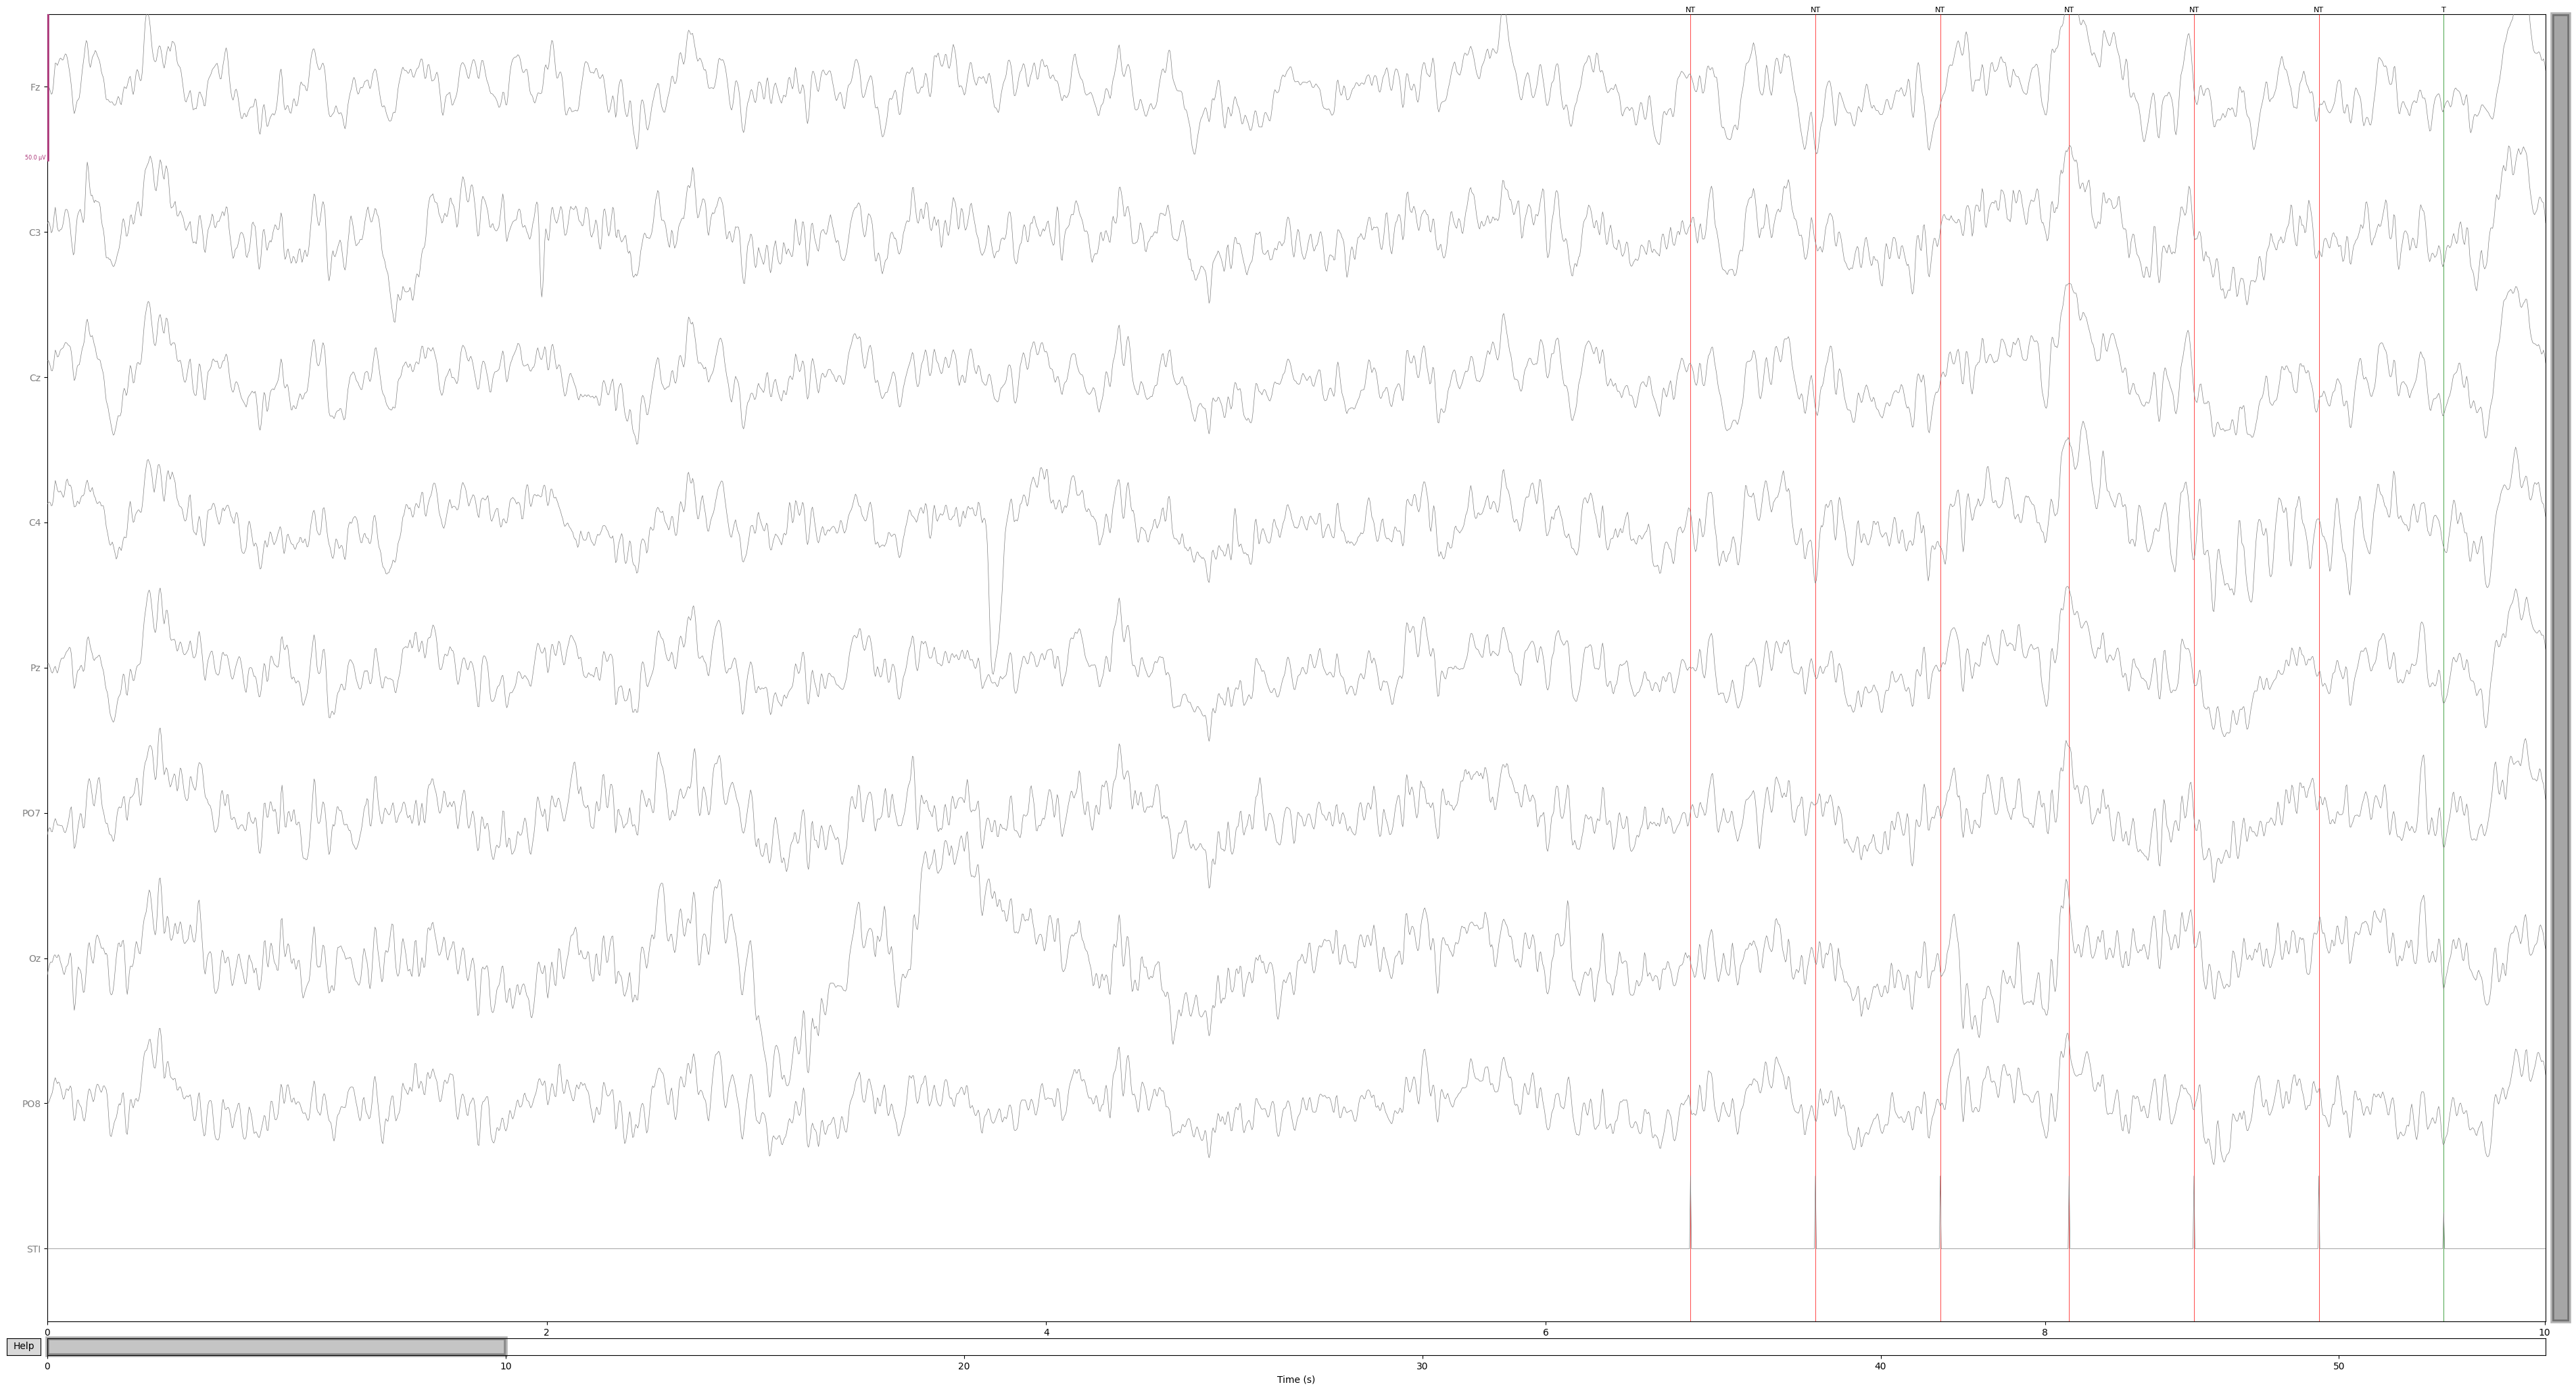

In [2]:
ev_ids = {'NT': 2, 'T':1}
event_colors = {2:'r', 1:'g'}
stim_channel = 'STI'
events = find_events(raw_data, stim_channel=stim_channel)
raw_data.plot(events=events, event_id=ev_ids, event_color=event_colors, color = 'Gray', block = True, clipping=None, scalings=25e-6)
plt.show()

#### 2.Preprocess the data
We apply the basic preprocessing steps to the data, such as bandpass filtering and notch filtering. The MNE functions have been wrapped by a single preprocessing pipeline.

In [3]:
filtered = basic_preprocessing_pipeline(raw_data, lp_freq=1, hp_freq=40, notch_freqs=(50,60))

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband e

#### 3.Epoching with baseline correction
The baseline segment is defined as the interval before the onset of the event. The mean of this interval is subtracted from the entire epoch to correct for the baseline shift.

In [4]:
baseline=(-.6, 0) 
eps = extract_epochs(data=filtered, events=events, ev_ids=ev_ids, tmin=-0.6, tmax=0.8, baseline=baseline)
eps.apply_baseline(baseline)

X = eps.get_data(picks='eeg')[:, :, 150:350]

y = eps.events[:,-1]

print(X.shape, y.shape)

Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 351 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
(90, 8, 200) (90,)


#### 4.Resample and split the data
There main reason for resampling the data is to avoid unbalanced classes. The number of samples in the minority class is much lower than the majority class. 
This can lead to a model that is biased towards the majority class. 
To avoid this, we can oversample the minority class or undersample the majority class (or both!).

In [33]:
random_state = 32

# Over-sampling the minority class and under-sampling the majority class
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=random_state)
undersampler = RandomUnderSampler(sampling_strategy=0.3, random_state=random_state)



# Assuming you have epochs of size (1, 8, 200)
num_epochs = len(X)
epoch_size = (1, 8, 200)

# Reshape the data for LDA
X_r = X.reshape(num_epochs, -1)
y_r = y
#X_r, y_r = oversampler.fit_resample(X_r, y_r) # Uncomment this line to oversample the minority class
#X_r, y_r = undersampler.fit_resample(X_r, y_r) # Uncomment this line to undersample the majority class

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_r, y_r, test_size=0.2, random_state=33)
print(X_train.shape, X_test.shape)

(72, 1600) (18, 1600)


### Classification
1. Linear Discriminant Analysis
2. Cross-Validation

#### 1.LinearDiscriminantAnalysis
For classification, we use LDA, a model that fits a Gaussian density for each class and has been shown to be a good classifier for ERP data in previous studies [1].
Other classifiers can be used, such as SVM, or variants of LDA such as QDA.
[1] D. J. Krusienski et al., “A comparison of classification techniques for the P300 Speller,” J Neural Eng, vol. 3, no. 4, pp. 299–305, Dec. 2006, doi: 10.1088/1741-2560/3/4/007.


Accuracy: 0.83 F1 Score: 0.00


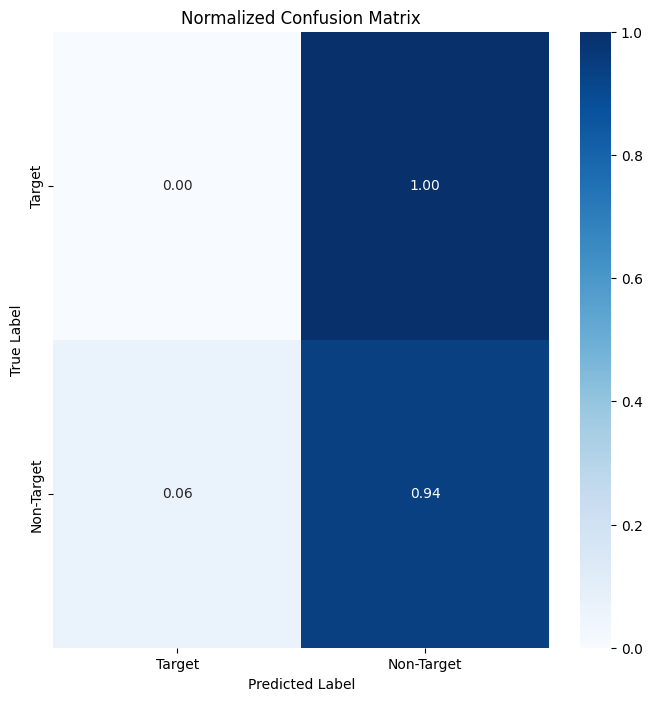

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Apply LDA
model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')

print(f'Accuracy: {accuracy:.2f} F1 Score: {f1:.2f}')
plot_confusion_matrix(y_test, y_pred, classes=['Target', 'Non-Target'], normalize=True)

#### 2.Cross-Validation

Cross-validated accuracy: 0.87 (+/- 0.10) F1-Score: 0.20


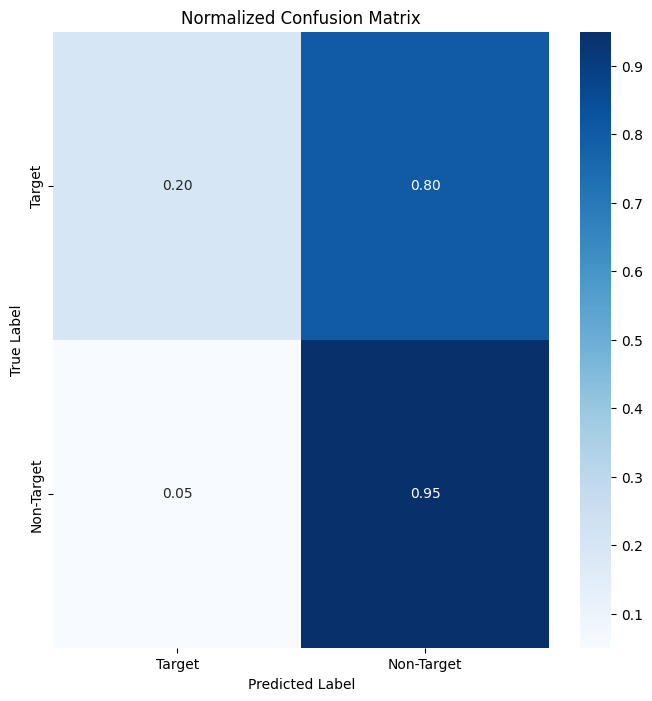

In [35]:
# Use cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(model, X_r, y_r, cv=cv)
f1 = cross_val_score(model, X_r, y_r, cv=cv, scoring='f1', error_score=0)


# Print cross-validated accuracy
print(f'Cross-validated accuracy: {np.mean(scores):.2f} (+/- {np.std(scores):.2f}) F1-Score: {np.mean(f1):.2f}')

plot_cross_validated_confusion_matrix(X_r, y_r, model, cv=cv, classes=['Target', 'Non-Target'], normalize=True)